<a href="https://colab.research.google.com/github/gonzo3832/machie-learning-papers/blob/main/notebooks/seg/sfnet_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# summary
sfnetの実装

論文：　https://arxiv.org/abs/2002.10120

flamework: tensor flow, keras

参考：

https://logmi.jp/tech/articles/325685

## SFNetについて
### 概要

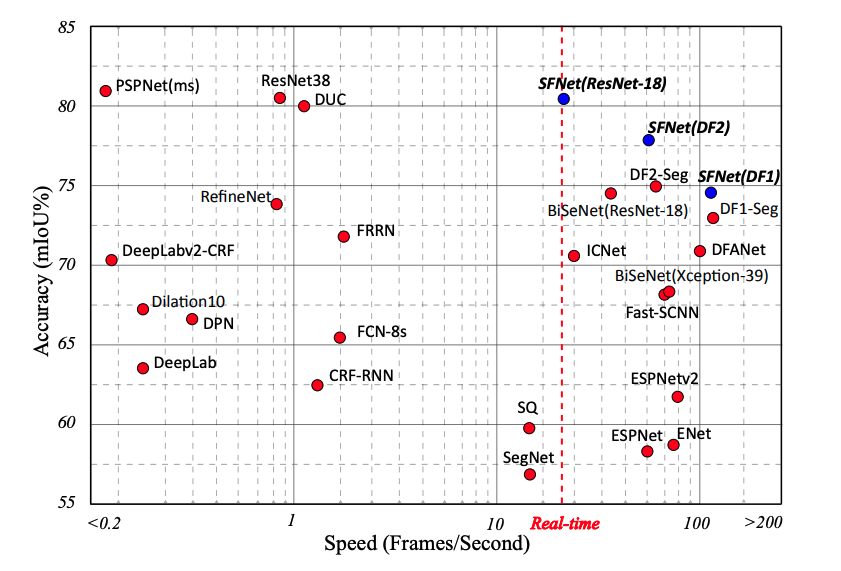

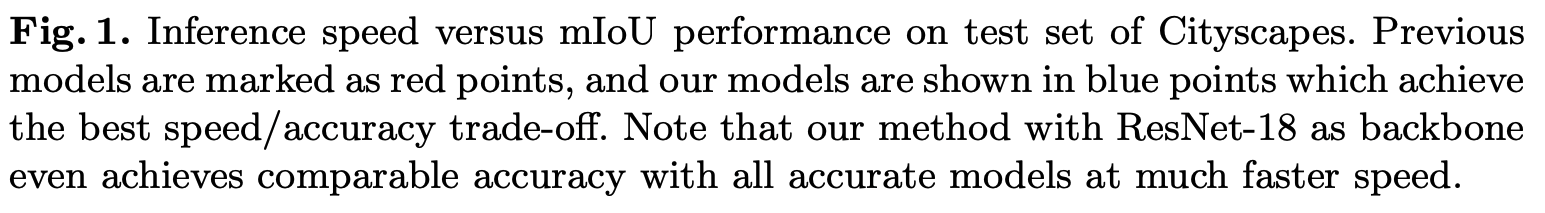

従来のsemantic segmentationでは、位置情報を保持するためにatrous convolution や　feature pyramid pooling を使用してきたが、計算量の多さに起因するfpsの低さを問題点として指摘。

解像度を維持しつつ、強い意味表現を獲得するもう一つの手法として、FPN（Feature Pyramid　Network)likeなアーキテクチャを構築する方法があるが、前述の手法と比較すると精度が低い。

精度の低さの原因として、筆者らは、強い意味情報を持つ深い層から浅い層への意味情報の伝搬が効果的でないことを推測。

この問題に対して、映像処理タスクで用いられるオプティカルフローにヒントを得て、特徴量map間のセマンティックフローを学習し、深い層における低解像度・高意味情報の特徴量mapを、浅い層の高解像度・低情報量の特徴量mapへブロードキャストするlow alignment moduleを提案。

これにより精度の向上を軽量化を実現し、Cityscapes datasetにおいて２６fpsで８０．４％のmIoUを達成した。

### アーキテクチャ
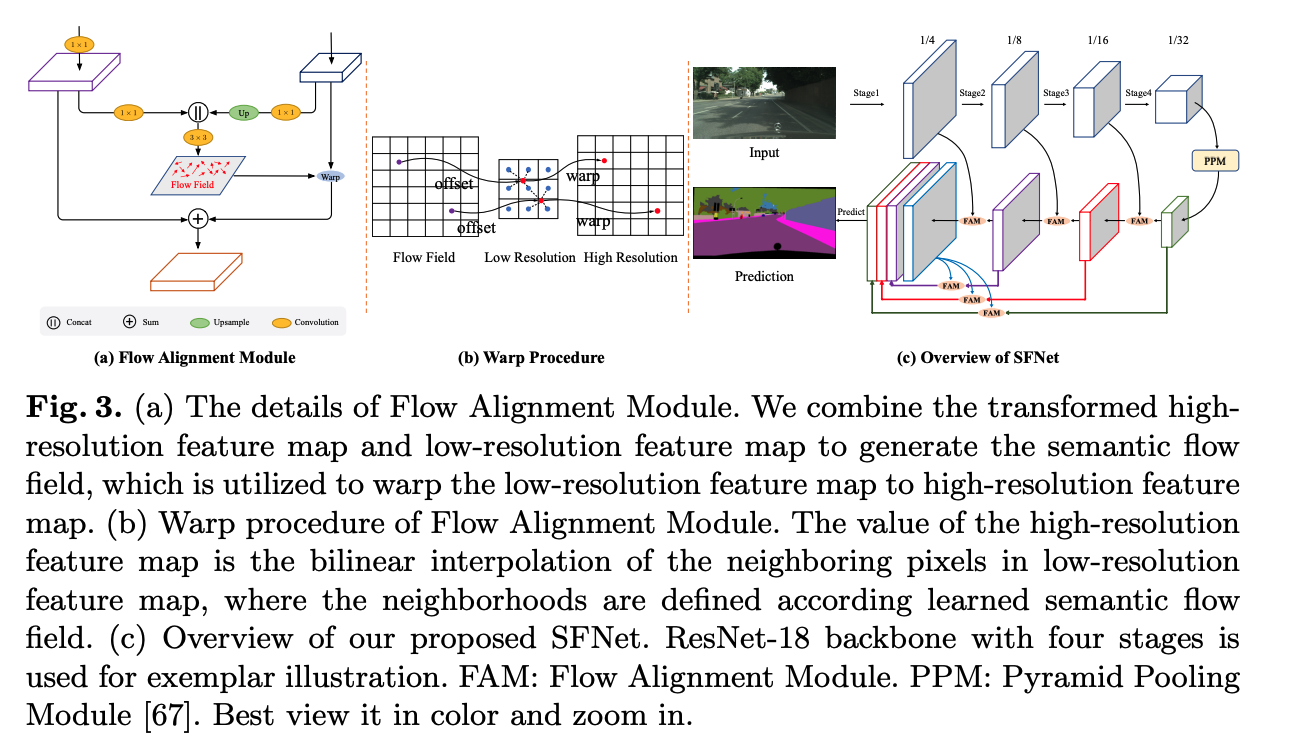

## import dependancies

In [1]:
! pip install tensorflow_addons
!pip install image-classifiers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 


In [2]:
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from IPython.display import clear_output
from classification_models.tfkeras import Classifiers

print(tf.__version__)


2.8.0


## common layerの実装
tfは基本的にinput channelの指定の必要なし

In [4]:
def BNReLU(norm_type=None,**kwargs):
    if norm_type == 'batchnorm':
        return keras.Sequential([
                                 layers.BatchNormalization(**kwargs),
                                 layers.ReLU()
        ])

def conv3x3_bn_relu(out_channels, stride=1, norm_type="batchnorm"):
    return keras.Sequential(
        [
         layers.Conv2D(filters=out_channels, kernel_size=3,strides=(stride,stride),padding='same',use_bias=False),
         BNReLU(norm_type=norm_type)
         ]
         )

def BatchNorm2d(norm_type=None, ret_cls=False):
        if norm_type == 'batchnorm':
            return layers.BatchNormalization

def grid_sample_2d(inp, grid): # https://stackoverflow.com/questions/52888146/what-is-the-equivalent-of-torch-nn-functional-grid-sample-in-tensorflow-numpy
    in_shape = tf.shape(inp)
    in_h = in_shape[1]
    in_w = in_shape[2]

    # Find interpolation sides
    i, j = grid[..., 0], grid[..., 1]
    i = tf.cast(in_h - 1, grid.dtype) * (i + 1) / 2
    j = tf.cast(in_w - 1, grid.dtype) * (j + 1) / 2
    _i_1 = tf.maximum(tf.cast(tf.floor(i), tf.int32), 0)
    _i_2 = tf.minimum(_i_1 + 1, in_h - 1)
    _j_1 = tf.maximum(tf.cast(tf.floor(j), tf.int32), 0)
    _j_2 = tf.minimum(_j_1 + 1, in_w - 1)

    # clip maximum value
    max_y = tf.cast(in_h - 1,'int32')
    max_x = tf.cast(in_w - 1,'int32')
    i_1 = tf.clip_by_value(_i_1,0,max_y)
    i_2 =tf.clip_by_value(_i_2,0,max_y) 
    j_1 =tf.clip_by_value(_j_1,0,max_x) 
    j_2 =tf.clip_by_value(_j_2,0,max_x) 


    # Gather pixel values
    n_idx = tf.tile(tf.range(in_shape[0])[:, tf.newaxis, tf.newaxis], tf.concat([[1], tf.shape(i)[1:]], axis=0))
    q_11 = tf.gather_nd(inp, tf.stack([n_idx, i_1, j_1], axis=-1))
    q_12 = tf.gather_nd(inp, tf.stack([n_idx, i_1, j_2], axis=-1))
    q_21 = tf.gather_nd(inp, tf.stack([n_idx, i_2, j_1], axis=-1))
    q_22 = tf.gather_nd(inp, tf.stack([n_idx, i_2, j_2], axis=-1))

    # Interpolation coefficients
    _di = tf.cast(i, inp.dtype) - tf.cast(i_1, inp.dtype)
    di = tf.expand_dims(_di, -1)
    _dj = tf.cast(j, inp.dtype) - tf.cast(j_1, inp.dtype)
    dj = tf.expand_dims(_dj, -1)

    # Compute interpolations
    q_i1 = q_11 * (1 - di) + q_21 * di
    q_i2 = q_12 * (1 - di) + q_22 * di
    q_ij = q_i1 * (1 - dj) + q_i2 * dj

    return q_ij



## PSP module の実装
sfnetのエンコーダパートの最終層で使用する。

https://arxiv.org/abs/1612.01105

In [5]:
class PSPModule(tf.keras.Model):
    def __init__(self, out_channels=512, sizes=(1,2,3,6), norm_type = "batchnorm"):
        super(PSPModule,self).__init__()

        self.sizes = sizes
        self.poolings = []
        self.stages =[self._make_stage( out_channels, size, norm_type) for size in sizes]
        self.bottleneck = keras.Sequential(
            [layers.Conv2D(filters=out_channels, kernel_size=1,use_bias=False),
            BNReLU(norm_type = norm_type), 
            layers.Dropout(0.1)                                            
        ])
        
    def _make_stage(self, out_channels, size, norm_type):
        # prior = tfa.layers.AdaptiveAveragePooling2D(output_size=(size,size),data_format='channels_last') # なんとinputをカーネルサイズで割り切れないとエラー吐く。どこがadaptiveなのか
        conv = layers.Conv2D(filters=out_channels, kernel_size=1,use_bias=False)
        bn = BatchNorm2d(norm_type=norm_type)()
        return keras.Sequential([ conv, bn])

    def call(self, feats):
        h, w = feats.shape[1], feats.shape[2]
        priors = []
        for i, size in enumerate(self.sizes):
            stride_h, stride_w = h // size, w // size
            kernel_h, kernel_w = h - (size - 1) * stride_h, w - (size - 1) * stride_w
            _feats = layers.AvgPool2D(pool_size=(kernel_h,kernel_w), strides=(stride_h, stride_w), padding='valid')(feats)
            _feats = self.stages[i](_feats) 
            _feats = tf.image.resize(_feats, [h,w], method=tf.image.ResizeMethod.BILINEAR) 
            priors.append(_feats)
        priors =priors + [feats]
        bottle = self.bottleneck(tf.concat(priors,3))
        
        return bottle

### flow alignment moduleの実装

In [6]:
class AlignModule(tf.keras.Model):
    def __init__(self,out_channels):
        super(AlignModule, self).__init__()
        self.down_h = layers.Conv2D(out_channels, kernel_size=1,use_bias=False)
        self.down_l = layers.Conv2D(out_channels, kernel_size=1,use_bias=False)
        self.flow_make = layers.Conv2D(2, kernel_size=3,padding='same', use_bias=False)
    
    def call(self, x):
        low_feature, high_feature = x
        high_feature_origin = high_feature
        h, w = low_feature.shape[1:3]
        size = [h,w]
        low_feature = self.down_l(low_feature)
        high_feature = self.down_h(high_feature)
        high_feature = tf.image.resize( high_feature, size, method=tf.image.ResizeMethod.BILINEAR) 
        flow = self.flow_make(tf.concat([high_feature, low_feature], 3))
        high_feature = self.flow_warp(high_feature_origin,flow,size=size)

        return high_feature
    def flow_warp(self,input,flow,size):
        out_h, out_w= size
        n, h, w, c = input.shape
        norm = tf.constant([[[[out_w, out_h]]]], dtype=input.dtype)
        w = tf.linspace(-1.0, 1.0, out_h)
        w = tf.reshape(w,[-1,1])
        w = tf.repeat(w,[out_w], axis=1)
        h = tf.linspace(-1.0, 1.0, out_w)
        h = tf.reshape(h, [1,-1])
        h = tf.repeat(h,[out_h],axis=0)
        grid = tf.concat([tf.expand_dims(h,2), tf.expand_dims(w,2)],2)
        grid = tf.expand_dims(grid,0)
        if n != None:
            grid = tf.tile(grid,[n,1,1,1])
        grid = grid + flow/norm
        output = grid_sample_2d(input,grid)
        return output

### AlignHead moduleの実装

いわゆるデコーダパート

In [7]:
class AlignHead(tf.keras.Model):
    def __init__(self, in_channels, norm_type="batchnorm", fpn_dim=256):
        super(AlignHead, self).__init__()
        self.ppm = PSPModule(norm_type=norm_type,out_channels=fpn_dim)
        fpn_in_channels =  [in_channels // 8, in_channels//4, in_channels//2,in_channels] 
        self.fpn_in = []
        for fpn_in_channel in fpn_in_channels[:-1]:
           self.fpn_in.append(
              keras.Sequential([
                  layers.Conv2D(fpn_dim,1),
                  BNReLU(norm_type=norm_type)
              ]) 
           )

        self.fpn_out = []
        self.fpn_out_align = []
        for i in range(len(fpn_in_channels) - 1):
            self.fpn_out.append(keras.Sequential(
                conv3x3_bn_relu(fpn_dim,stride=1),
            ))
            self.fpn_out_align.append(
                AlignModule(out_channels=fpn_dim//2)
            )
    def call(self, conv_out):
        psp_out = self.ppm(conv_out[-1])

        f = psp_out
        fpn_feature_list = [psp_out]
        out = []
        for i in reversed(range(len(conv_out)-1)):
            conv_x = conv_out[i]
            conv_x = self.fpn_in[i](conv_x)
            f = self.fpn_out_align[i]([conv_x, f]) 
            f = conv_x + f
            fpn_feature_list.append(self.fpn_out[i](f))
            out.append(f)
        
        fpn_feature_list.reverse()
        output_size = fpn_feature_list[0].shape[1:3]
        fusion_list = [fpn_feature_list[0]]

        for i in range(1, len(fpn_feature_list)):
            fusion_list.append(
                tf.image.resize( 
                    fpn_feature_list[i],
                    output_size, 
                    method=tf.image.ResizeMethod.BILINEAR
                    )
            ) 
        fusion_out = tf.concat(fusion_list,3)
        return fusion_out, out
        

### SFNet(backborn: Resnet18)の実装

論文ではimagenetでpretrainしたResnet18をバックボーンとしているが、tensorflow公式でResnet１８をサポートしていなかったため、以下から拝借。

https://github.com/qubvel/classification_models

In [8]:
ResNet18, preprocess_input = Classifiers.get('resnet18')

class ResSFNet(tf.keras.Model):
    def __init__(self, num_classes, input_shape=(600,600,3)):
        super(ResSFNet, self).__init__()
        base = ResNet18(input_shape = input_shape,include_top=False, weights = 'imagenet', classes = 1) #only use internal layer
        self.num_classes = num_classes 
        self.stage1 = tf.keras.Model(inputs = base.get_layer(index=0).input,outputs = base.get_layer(index=26).output)
        self.stage2 = tf.keras.Model(inputs = base.get_layer(index=27).input,outputs = base.get_layer(index=45).output)
        self.stage3 = tf.keras.Model(inputs = base.get_layer(index=46).input,outputs = base.get_layer(index=64).output)
        self.stage4 = tf.keras.Model(inputs = base.get_layer(index=65).input,outputs = base.get_layer(index=83).output)

        del base
        
        num_features = 512
        fpn_dim = 128
        self.head = AlignHead(num_features, fpn_dim=fpn_dim)
        self.conv_last = keras.Sequential(
            [
             conv3x3_bn_relu(fpn_dim, 1),
             layers.Conv2D(self.num_classes, kernel_size=1)
             ]
             )
    def call(self, input):
        target_size = input.shape[1:3]
        x1 = self.stage1(input)
        x2 = self.stage2(x1)
        x3 = self.stage3(x2)
        x4 = self.stage4(x3)
        x_ = [x1, x2, x3, x4]
        x, fpn_dsn = self.head(x_)
        x = self.conv_last(x)
        x = tf.image.resize( 
                    x,
                    target_size, 
                    method=tf.image.ResizeMethod.BILINEAR
                    )

        return x 
        
        

## 動作確認
oxford IIIT pet datasetを使用。



In [9]:
dataset, info =tfds.load('oxford_iiit_pet:3.*.*', with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteHF2590/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteHF2590/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [49]:
TRAIN_LENGTH = info.splits['train'].num_examples
HEIGHT = 600
WIDTH = 600
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [50]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [51]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [52]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH ))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [62]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [63]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

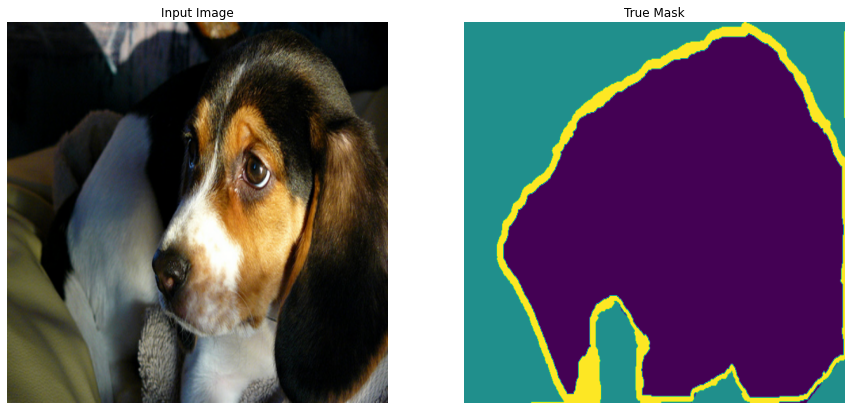

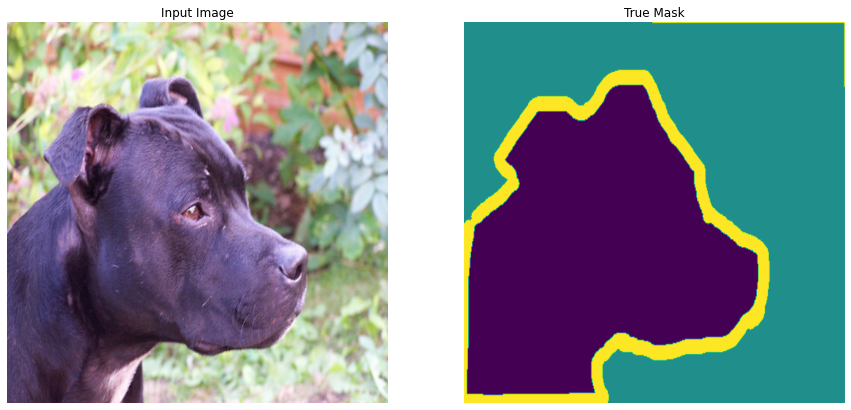

In [64]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [65]:
train_images = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_images = dataset['test'].map(load_image_test)

In [66]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [67]:
OUTPUT_CHANNELS = 3

In [68]:
model = ResSFNet(OUTPUT_CHANNELS,(HEIGHT,WIDTH,3))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [69]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [70]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [71]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    

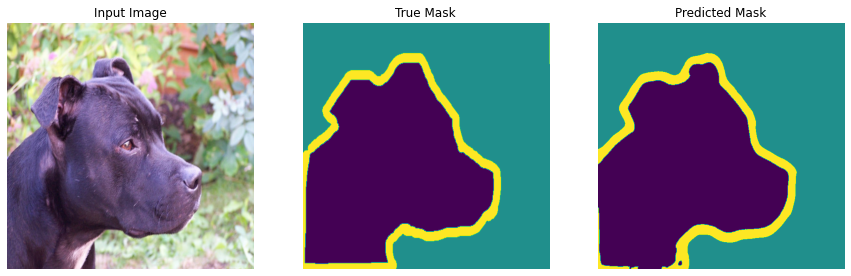


Sample Prediction after epoch 10

230/230 [==============================] - 75s 325ms/step - loss: 0.1387 - accuracy: 0.9372 - val_loss: 0.2237 - val_accuracy: 0.9153


In [72]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks = [DisplayCallback()]
                          )

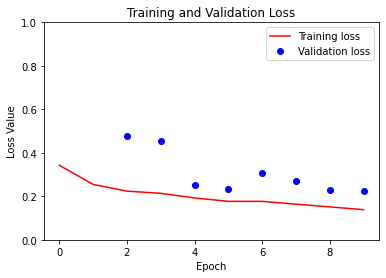

In [73]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

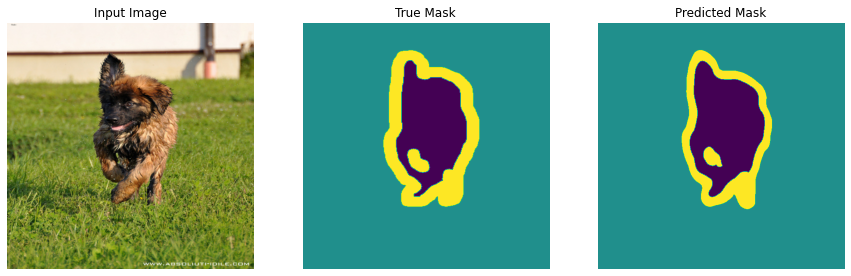

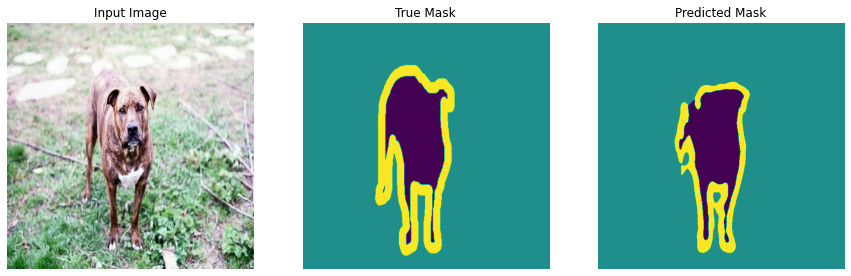

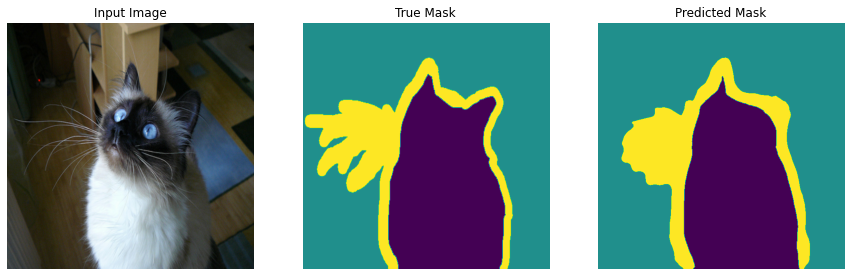

In [74]:
show_predictions(test_batches, 3)